In [1]:
# Used dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier

The dataset in use contains 10k entries with a 50/50 split (legit URL: CLASS_LABEL=0 / phishing URL: CLASS_LABEL=1).

To validate there were no null entries, an initial first check of the data was performed.

In [2]:
df = pd.read_csv('./files/Phishing_Legitimate_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

As a first step, and since this is all available data for training and testing the model, dataset was splitted in two subsets:
70% for the training;
30% for further testing.
It was decided to keep the same 50/50 ratio in the two subsets for two main reasons:
1. Ensure both training and testing datasets have the same class distribution for a more consistent aand meaningful evaluation.
2. In real world scenario, it's preferable to have false-positives than false-negatives. Since in real world the proportion of positives is usually below 50%, testing the model on a dataset with higher positive ratio will force stricter requirements for detecting true-positives.

In [ ]:
df_pos = df.iloc[:5000].sample(frac=1, random_state=5).reset_index(drop=True)
df_neg = df.iloc[5000:].sample(frac=1, random_state=5).reset_index(drop=True)
df_shuffled = pd.concat([df_pos, df_neg], ignore_index=True)

df_test = df_shuffled.iloc[np.r_[0:1500, 8500:10000]]
df_train = df_shuffled.iloc[1500:-1500].reset_index(drop=True)

df_test.to_csv('./files/data_for_testing.csv', index=False)
df_train.to_csv('./files/data_for_training.csv', index=False)

From this point, only the database "data_for_training.csv" will be used for modeling and optimization of the model, while the "data_for_testing.csv" should only be used at a final phase, for testing the model with unseen data.

In [2]:
data = pd.read_csv('./files/data_for_training.csv')
data = data.drop(columns=['id'])

Let's start with a generic analysis of the data and understanding if ranges and order of magnitude of the features vary significantly.

In [15]:
data.describe()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,2.436000,0.583286,3.296286,70.031571,1.808571,0.141714,0.000429,0.014571,0.315000,0.066143,...,0.340857,0.031714,0.032571,0.959429,0.021143,0.346571,0.794000,0.174000,0.310571,0.500000
std,1.316004,0.739497,1.879401,32.871543,3.079726,0.550289,0.020699,0.119838,1.089142,0.541779,...,0.474031,0.175251,0.177525,0.238607,0.818321,0.892189,0.521977,0.754476,0.899335,0.500036
min,1.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,3.000000,1.000000,4.000000,83.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21.000000,14.000000,18.000000,253.000000,26.000000,9.000000,1.000000,1.000000,14.000000,16.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Many of the features on our data are either boolean (0/1) or in fractional range (0-1), while others may range to hundreds order of magnitude. This is an important consideratio to have in case these features are used, particularly for some models.

This table analysis is not very visually applealing to identify potential patterns, so let's proceed with graphical representations.
Different data representtions can be performed to help looking for meaninful, or unmeaningful, features in our data. For a learning purpose and to support on the learning, let's look at a few.

A simple histogram chart representation can provide a good overview of each feature distribution.

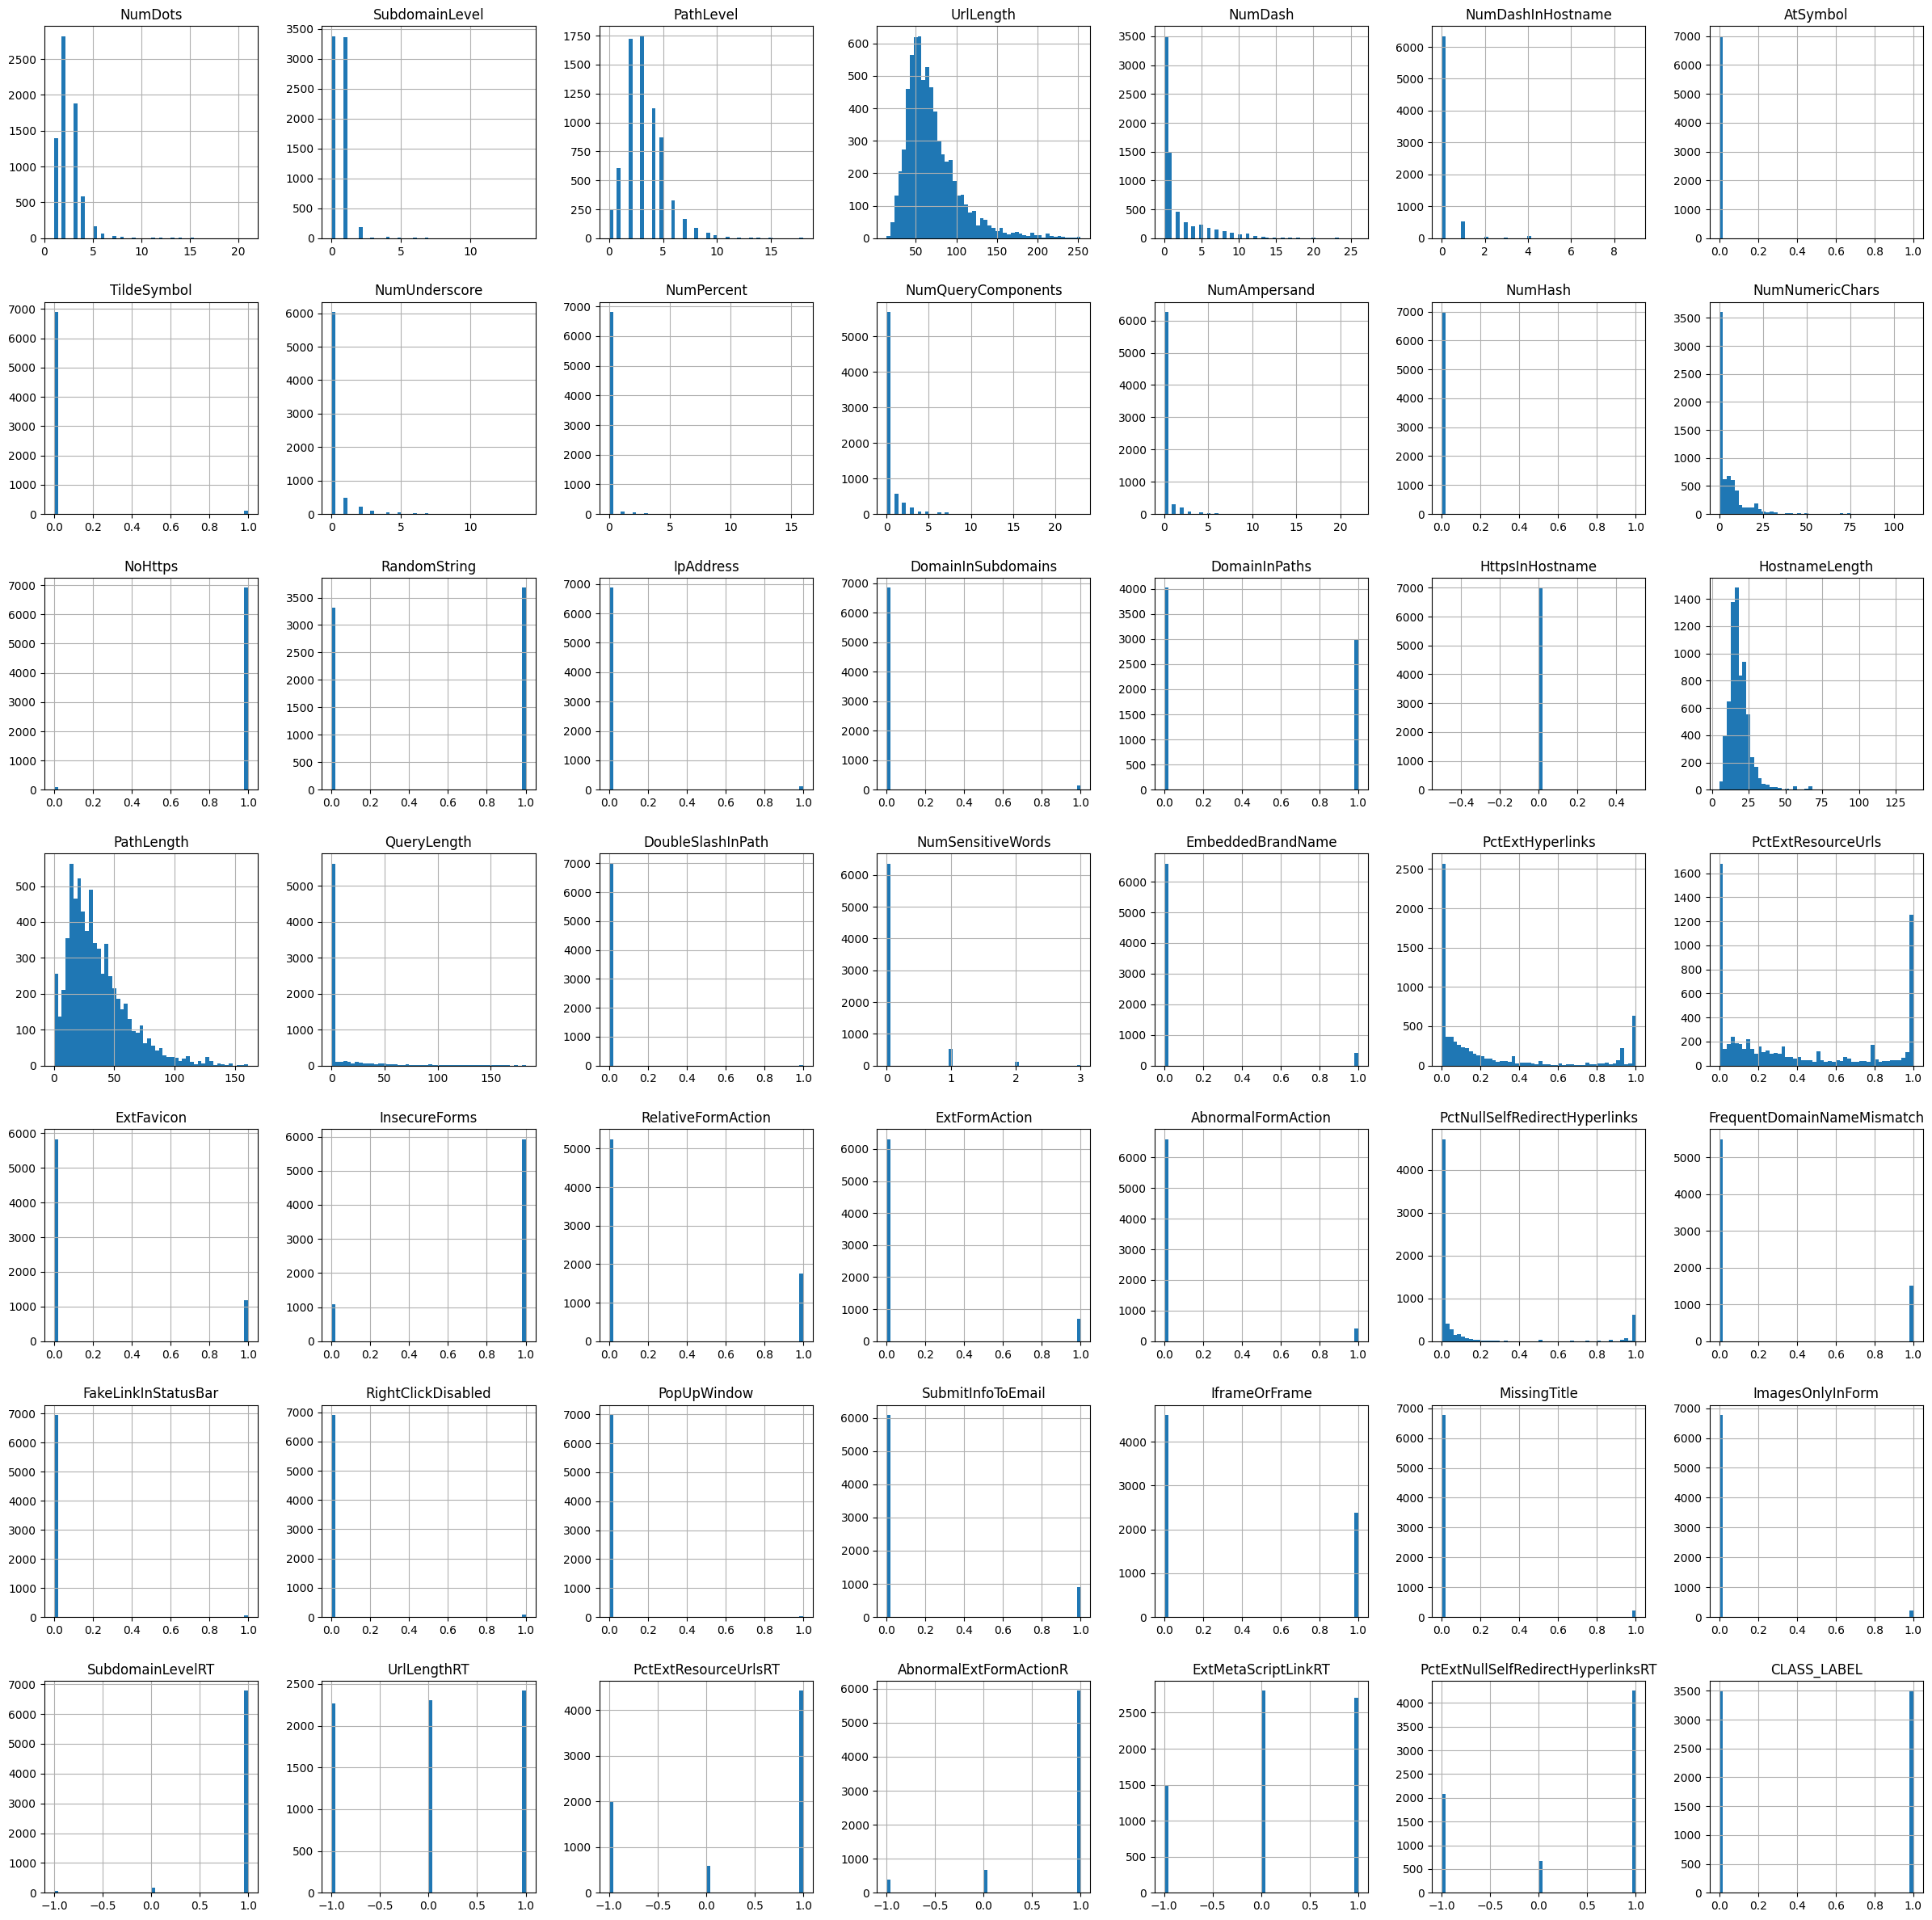

In [16]:
data.hist(bins=50,figsize=(30,30))
pyplot.show()

A good variant, is performing a bar chart applying different colors to positive and negative data. This allows to have a more clear idea if the feature will be meaningfull in identifying positive cases.

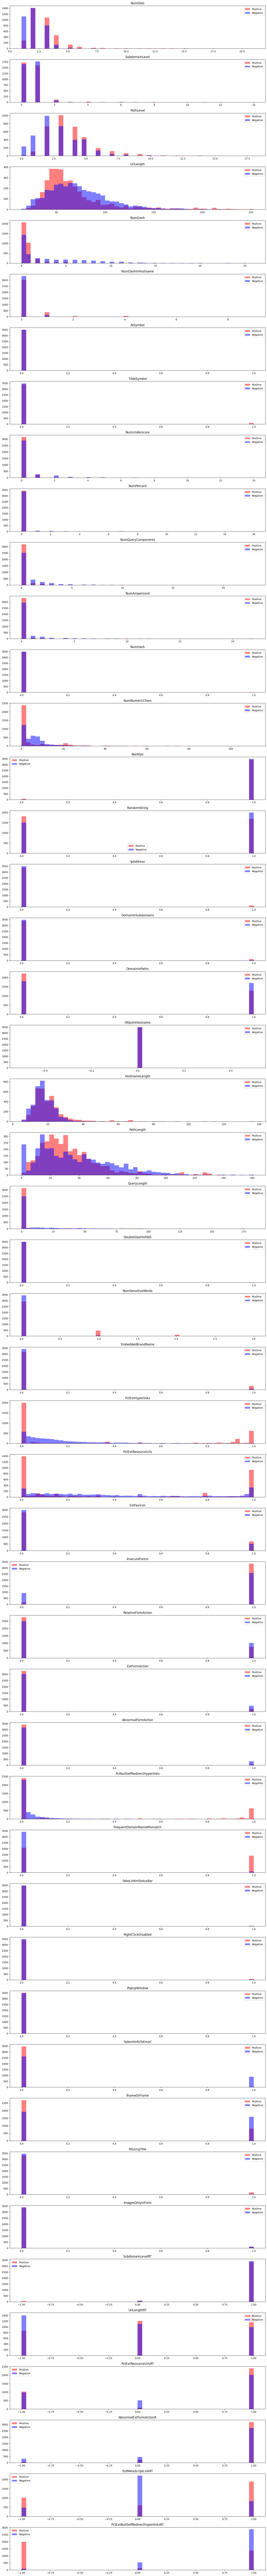

In [17]:
num_columns = len(data.columns) - 1
fig, axes = pyplot.subplots(nrows=num_columns, figsize=(15, num_columns * 3))

for i, column in enumerate(data.columns):
    if column != 'CLASS_LABEL':
        ax = axes[i]
        positive_data = data[data['CLASS_LABEL'] == 1][column]
        negative_data = data[data['CLASS_LABEL'] == 0][column]
        combined_data = pd.concat([positive_data, negative_data])
        bin_edges = np.histogram_bin_edges(combined_data, bins=50)
        ax.hist(positive_data, bins=bin_edges, alpha=0.5, label='Positive', color='red')
        ax.hist(negative_data, bins=bin_edges, alpha=0.5, label='Negative', color='blue')
        ax.set_title(column)
        ax.legend()

pyplot.tight_layout()
pyplot.show()

Another great way of looking at data separatly (each feature individually) is by performing a boxplot.

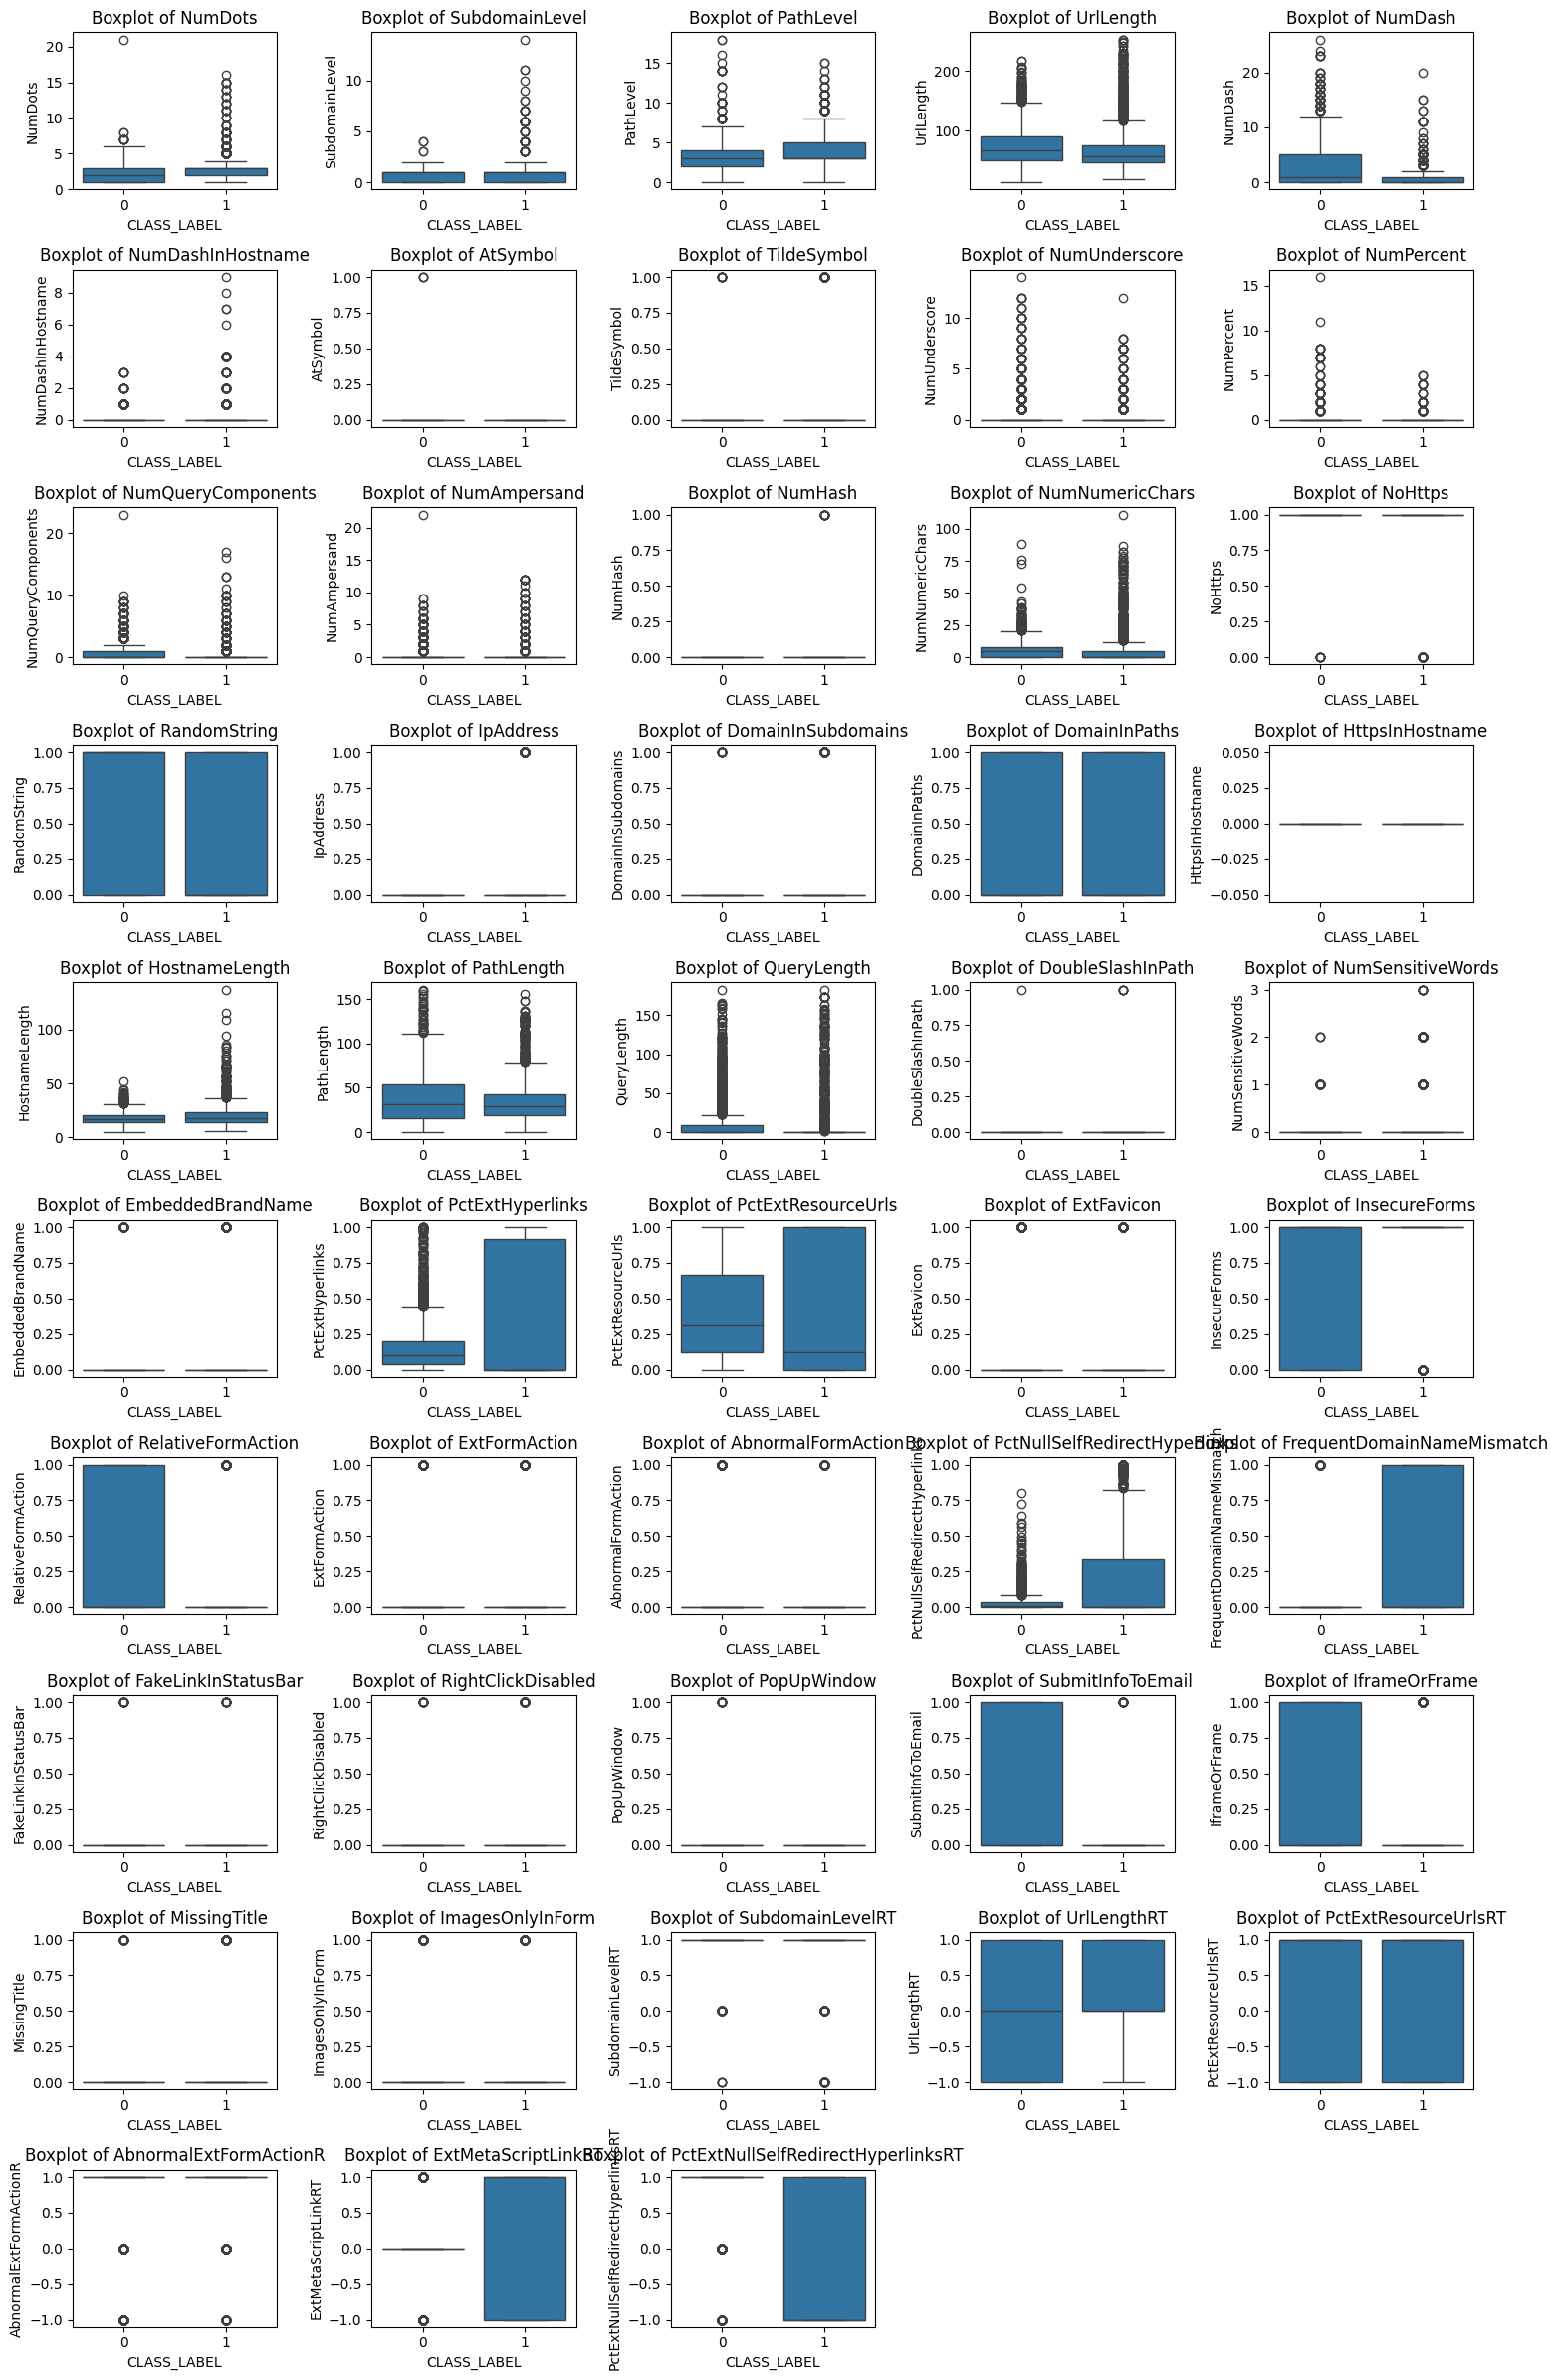

In [8]:
num_columns = len(data.columns) - 1
fig, axes = pyplot.subplots(nrows=(num_columns+5-1)//5, ncols=5, figsize=(15, num_columns * 0.5))
axes = axes.flatten()

plot_index = 0
for column in data.columns:
    if column != 'CLASS_LABEL':
        sb.boxplot(x='CLASS_LABEL', y=column, data=data, ax=axes[plot_index])
        axes[plot_index].set_title(f'Boxplot of {column}')
        plot_index += 1

for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

pyplot.tight_layout()
pyplot.show()

It's also relevant to look for correlations between different features, and not only each individually against the CLASS_LABEL. The Correlation Matrix is a good technic to look for potential correlation between features, not diretly visible in histogram or boxplot graphs.

<function matplotlib.pyplot.show(close=None, block=None)>

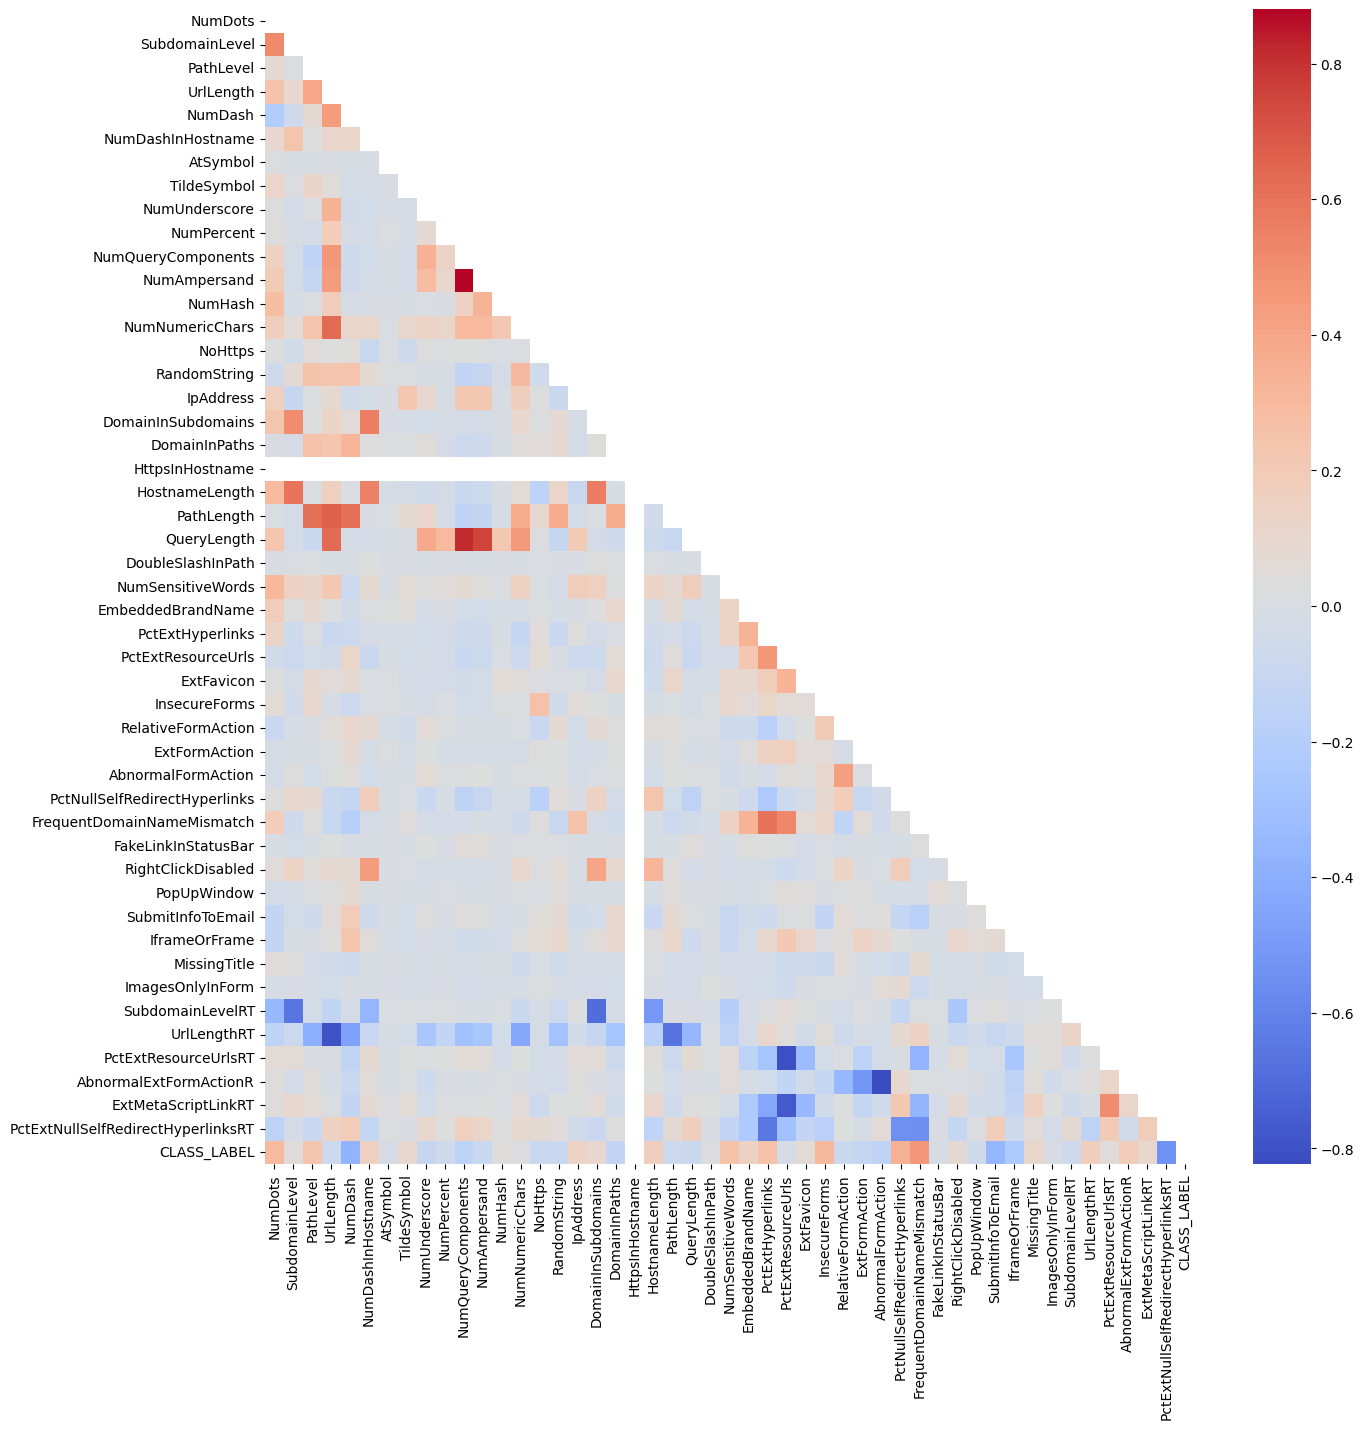

In [21]:
corr_mat = data.corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
pyplot.figure(figsize=(15,15))
sb.heatmap(corr_mat, mask=mask, cmap='coolwarm')
pyplot.show

Another great way to identify links between features that might be helpful to correlate with the CLASS_LABEL is by directly making a scatter plot of each feature agaist the other, applying different colors for each CLASS_LABEL. Below is just a few examples that were found interesting, but multiple combinations can be tested.

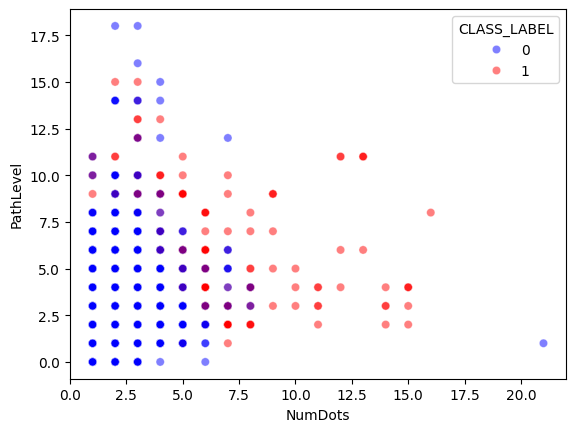

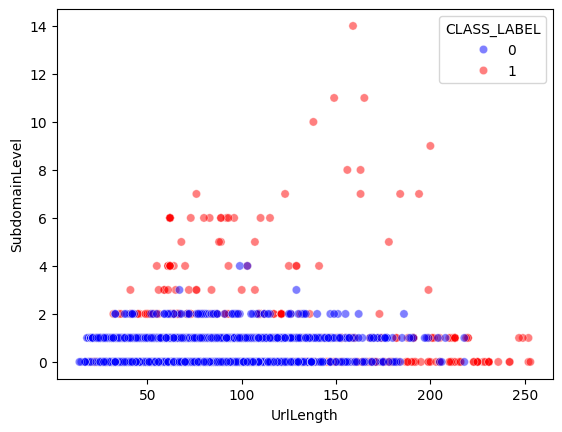

In [36]:
# First plot
sb.scatterplot(
    x='NumDots',
    y='PathLevel',
    hue='CLASS_LABEL',
    data=data,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)
pyplot.show()

#Second plot
sb.scatterplot(
    x='UrlLength',
    y='SubdomainLevel',
    hue='CLASS_LABEL',
    data=data,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)
pyplot.show()

Another good mathematical way to identify relevant features, without relying on visual interpretation, is to perform a feature importance calculation using a Random Forest model. To have a proper baseline on the relevance of this data, we will add a feature made of random data, data we know should not have relevant importance.

In [41]:
data['Random'] = np.random.uniform(-1, 1, size=len(data))

X = data.drop(columns=['CLASS_LABEL'])
y = data['CLASS_LABEL']

model = RandomForestClassifier(random_state=5)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)
print(sorted_importances.round(4))

data.drop(columns=['Random'], inplace=True)

PctExtHyperlinks                      0.2082
PctExtNullSelfRedirectHyperlinksRT    0.1490
FrequentDomainNameMismatch            0.0932
PctExtResourceUrls                    0.0740
PctNullSelfRedirectHyperlinks         0.0687
NumDash                               0.0448
ExtMetaScriptLinkRT                   0.0359
NumNumericChars                       0.0347
SubmitInfoToEmail                     0.0305
InsecureForms                         0.0286
PathLevel                             0.0241
NumDots                               0.0227
PathLength                            0.0187
QueryLength                           0.0149
UrlLength                             0.0146
NumSensitiveWords                     0.0141
IframeOrFrame                         0.0121
NumQueryComponents                    0.0111
ExtFavicon                            0.0109
HostnameLength                        0.0108
Random                                0.0086
PctExtResourceUrlsRT                  0.0080
NumAmpersa

Filtering the proper features is a very important step for training a machine learning model, since including unmeaningful features will just create noise and lead to a less efficient model.
After some data analysis, a set of features was selected to be used in the model training.

In [3]:
columns_to_keep = [
    'NumDots', 
    'SubdomainLevel', 
    'PathLevel', 
    'UrlLength', 
    'NumDash', 
    'NumDashInHostname',
    'NumQueryComponents', 
    'NumNumericChars', 
    'NoHttps', 
    'IpAddress',
    'PctExtHyperlinks', 
    'PctExtResourceUrls', 
    'PctNullSelfRedirectHyperlinks',
    'FrequentDomainNameMismatch', 
    'SubmitInfoToEmail', 
    'ExtMetaScriptLinkRT', 
    'PctExtNullSelfRedirectHyperlinksRT', 
    'TildeSymbol', 
    'NumUnderscore', 
    'NumAmpersand', 
    'RandomString', 
    'DomainInPaths', 
    'HostnameLength', 
    'PathLength',
    'QueryLength', 
    'NumSensitiveWords', 
    'InsecureForms', 
    'IframeOrFrame', 
    'CLASS_LABEL'
]

cleaned_training = data[columns_to_keep]
cleaned_training.to_csv(r'./files/training_features_cleaned.csv', index=False)

# Also separating the testing data to keep only the same columns
test_data = pd.read_csv('./files/data_for_testing.csv')
cleaned_testing = test_data[columns_to_keep]
cleaned_testing.to_csv(r'./files/testing_features_cleaned.csv', index=False)